# FPP optimization workflow 

In [11]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Debug);

## Make new FPP equilibirum from scratch

### Initialize from FPP v1_demount

In [12]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:FPP, version=:v2, init_from=:scalars);

### Modify ini

In [13]:
ini.equilibrium.R0 = 5.0
ini.equilibrium.B0 = 6.0
ini.equilibrium.ip = 8.75e6
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 0.8826 # set less than one so that init uses this as the f_kappa parameter
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.7e6

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.7
ini.core_profiles.greenwald_fraction = 1.0
ini.core_profiles.ne_ped = missing
ini.core_profiles.greenwald_fraction_ped = 0.7
ini.core_profiles.helium_fraction = 0.04
ini.core_profiles.zeff = 1.1

ini.build.plasma_gap = 0.125
ini.equilibrium.xpoints = :lower
ini.build.divertors = :lower
ini.build.symmetric = false

ini.ec_launcher[1].power_launched = 20e6

ini.pf_active.n_coils_outside = 6

ini.requirements.flattop_duration = 24*3600.0

86400.0

In [14]:
R0 = ini.equilibrium.R0
ϵ = ini.equilibrium.ϵ
a = R0*ϵ

RiPlasma = R0 - a

ini.build.layers = layers = FUSE.OrderedCollections.OrderedDict{Symbol,Float64}()

# HFS layers

layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
layers[:hfs_first_wall] = 0.02
layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
layers[:hfs_high_temp_shield] = RiPlasma*0.05
layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

rbCenterPost = (R0 - 0.5*layers[:plasma] - layers[:hfs_first_wall] - layers[:hfs_blanket]
    - layers[:hfs_high_temp_shield] - layers[:hfs_gap_high_temp_shield_vacuum_vessel]
    - layers[:hfs_vacuum_vessel] - layers[:hfs_gap_vacuum_vessel_low_temp_shield]
    - layers[:hfs_low_temp_shield] - layers[:hfs_gap_low_temp_shield_TF]);

layers[:hfs_TF] = rbCenterPost * 0.25
layers[:OH] = rbCenterPost * 0.25
layers[:gap_TF_OH] = RiPlasma * 0.02
layers[:gap_OH] = rbCenterPost - layers[:hfs_TF] - layers[:gap_TF_OH] - layers[:OH]

# LFS layers

layers[:lfs_first_wall] = 0.02
layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
layers[:lfs_high_temp_shield] = RiPlasma * 0.05
layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.4
layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
layers[:lfs_TF] = layers[:hfs_TF]

layers = ini.build.layers;


### Modify act

In [15]:
act.ActorEquilibrium.model = :TEQUILA
act.ActorEquilibrium.symmetrize = false

act.ActorECsimple.rho_0 = 0.6
act.ActorECsimple.width = 0.05

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 1.0

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.error_on_performance = false
act.ActorFluxSwing.operate_oh_at_j_crit = true

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.update_equilibrium = true
act.ActorPFcoilsOpt.optimization_scheme = :currents

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false

act.ActorCosting.model = :GASC
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_pedestal = 1.0
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio

act.ActorCoreTransport.model = :FixedProfiles #:FluxMatcher
act.ActorTGLF.user_specified_model = "sat1_em_fpp"
act.ActorFluxMatcher.do_plot = true
act.ActorFluxMatcher.verbose = true
act.ActorFluxMatcher.step_size = 1.0
act.ActorFluxMatcher.max_iterations = 200
#act.ActorFluxMatcher.rho_transport = [0.3,0.55,0.8]
act.ActorFluxMatcher.optimizer_algorithm = :anderson
act.ActorFluxMatcher.evolve_densities = Dict(
    :He4 => :match_ne_scale,
    :Kr83 => :match_ne_scale,
    #:Ne20 => :match_ne_scale,
    :DT => :quasi_neutrality,
    :DT_fast => :constant,
    :He4_fast => :constant, 
    :electrons => :flux_match,
    )

act.ActorStationaryPlasma.convergence_error = 1e-2
act.ActorStationaryPlasma.max_iter = 5
act.ActorStationaryPlasma.do_plot = true

act.ActorPFcoilsOpt.weight_null = 0.0


0.0

## Run WholeFacility Actor

In [17]:
dd = IMAS.dd()
@time FUSE.init(dd, ini, act; do_plot=false);

[ Info: Equilibrium
[ Info:  TEQUILA


[ Info: HCD


[ Info:  ECsimple
[ Info:  ICsimple


[ Info:  LHsimple


[ Info:  NBsimple


[ Info: SteadyStateCurrent


[ Info: CXbuild


 12.613508 seconds (36.93 M allocations: 10.956 GiB, 5.01% gc time)


[ Info: WholeFacility


Jtor0_before = 0.59 MA/m²
P0_before = 1851.76 kPa
βn_MHD = 5.32
βn_tot = 4.43
Te_ped = 3.43e+03 eV
rho_ped = 0.9500


[ Info:  StationaryPlasma


[ Info:   HCD
[ Info:    ECsimple


[ Info:    ICsimple
[ Info:    LHsimple


[ Info:    NBsimple


[ Info:   Current


[ Info:    SteadyStateCurrent


[ Info:   CoreTransport
[ Info:    FixedProfiles


[ Info:     Pedestal


[ Info:   HCD


[ Info:    ECsimple
[ Info:    ICsimple


[ Info:    LHsimple


[ Info:    NBsimple


[ Info:   Current
[ Info:    SteadyStateCurrent


[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 0.81 MA m^2
   P0_after = 1851.78 kPa
     βn_MHD = 4.56
     βn_tot = 4.26
     Te_ped = 2.47e+03 eV
    rho_ped = 0.9404


[ Info: Iteration = 1 , convergence error = 0.0591, threshold = 0.01


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal


[ Info:   HCD
[ Info:    ECsimple


[ Info:    ICsimple
[ Info:    LHsimple


[ Info:    NBsimple


[ Info:   Current
[ Info:    SteadyStateCurrent


[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 0.62 MA m^2
   P0_after = 1851.78 kPa
     βn_MHD = 4.17
     βn_tot = 4.37
     Te_ped = 2.09e+03 eV
    rho_ped = 0.9561


[ Info: Iteration = 2 , convergence error = 0.05769, threshold = 0.01


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal


[ Info:   HCD
[ Info:    ECsimple


[ Info:    ICsimple
[ Info:    LHsimple


[ Info:    NBsimple


[ Info:   Current
[ Info:    SteadyStateCurrent


[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 0.88 MA m^2
   P0_after = 1851.78 kPa
     βn_MHD = 4.02
     βn_tot = 4.26
     Te_ped = 1.97e+03 eV
    rho_ped = 0.9398


[ Info: Iteration = 3 , convergence error = 0.04832, threshold = 0.01


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal


[ Info:   HCD
[ Info:    ECsimple


[ Info:    ICsimple


[ Info:    LHsimple
[ Info:    NBsimple


[ Info:   Current
[ Info:    SteadyStateCurrent


[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 0.97 MA m^2
   P0_after = 1851.78 kPa
     βn_MHD = 4.20
     βn_tot = 4.19
     Te_ped = 1.97e+03 eV
    rho_ped = 0.9360


[ Info: Iteration = 4 , convergence error = 0.01783, threshold = 0.01


[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal


[ Info:   HCD
[ Info:    ECsimple


[ Info:    ICsimple


[ Info:    LHsimple


[ Info:    NBsimple


[ Info:   Current
[ Info:    SteadyStateCurrent


[ Info:   Equilibrium
[ Info:    TEQUILA


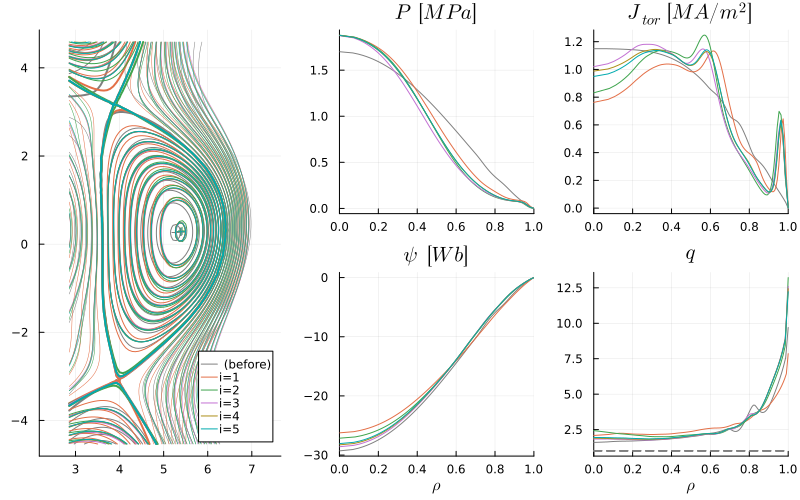

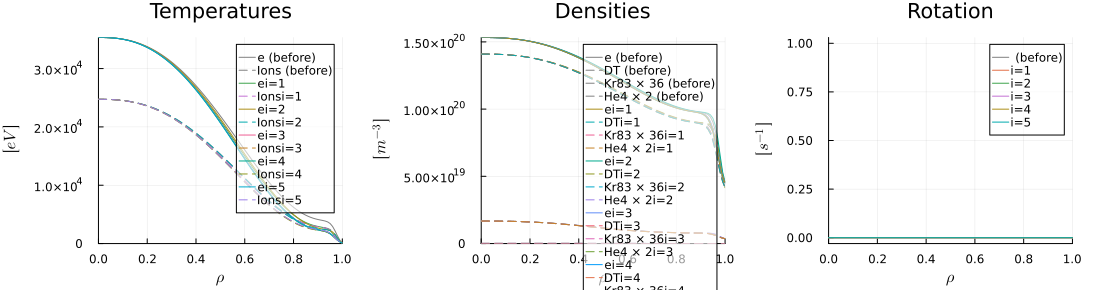

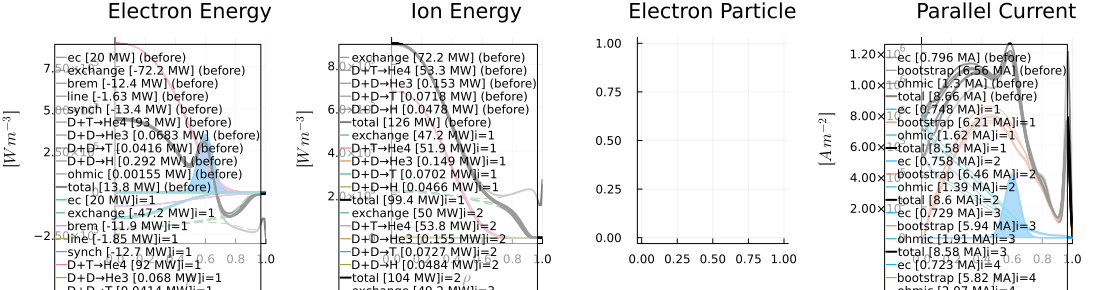


Jtor0_after = 0.91 MA m^2
   P0_after = 1851.78 kPa
     βn_MHD = 4.20
     βn_tot = 4.20
     Te_ped = 2.05e+03 eV
    rho_ped = 0.9363


[ Info: Iteration = 5 , convergence error = 0.00819, threshold = 0.01


[ Info:  StabilityLimits


[ Info:  HFSsizing


[ Info:   FluxSwing


[ Info:   Stresses


[ Info:   FluxSwing


[ Info:   Stresses


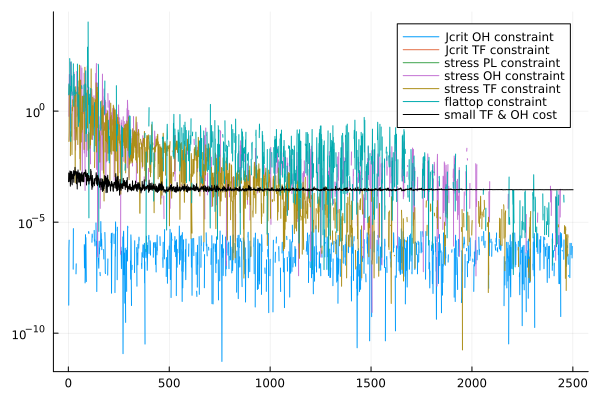

(0.0002874737491098581, [-4.6645383990204456e-7, -9.915796551262511e-6, -7.141079114989994e-7, -0.06721191912290712, -6.553763325353616e-7, 0.0], [0.0])
Optimization Result
  Iteration:       50
  Minimum:         0.000287474
  Minimizer:       [0.290067, 0.206953, 0.750164, 0.79963]
  Function calls:  2500
  Feasibles:       50 / 50 in final population
  Total time:      4.5616 s
  Stop reason:     Maximum number of iterations exceeded.
[PL.thickness] = 

[1.0590358139794958]
[OH.thickness, dd.build.oh.technology.fraction_steel] = [0.2763656784876645, 0.7501638702089839]
[TFhfs.thickness, dd.build.tf.technology.fraction_steel] = [0.5748066101690281, 0.7996301384878488]

target_B0 = 6.000083467996523
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 6.0066001972866125

dd.build.oh.flattop_duration = 95065.40440283291
dd.requirements.flattop_duration = 86400.0
dd.build.oh.flattop_duration / dd.requirements.flattop_duration = 1.1002940324401957

dd.build.oh.max_j = 4.585116279127049e7
dd.build.oh.critical_j = 6.882374903666145e7
dd.build.oh.critical_j / dd.build.oh.max_j = 1.5010251615639432

dd.build.tf.max_j = 2.4540769433934122e7
dd.build.tf.critical_j = 4.969461280101552e7
dd.build.tf.critical_j / dd.build.tf.max_j = 2.0249818545745977

maximum(cs.stress.vonmises.oh) = 7.895850013586676e8
cs.properties.yield_strength.oh = 8.0e8
cs.properties.yield_strength.oh / maximum(cs.stress.vonmises.oh) = 1.0131904717331395

maximum(cs.stress.vo

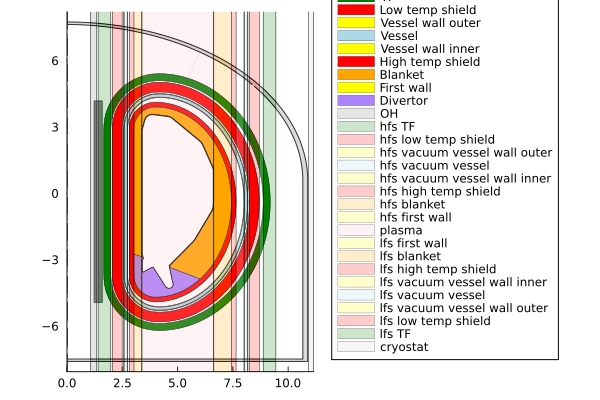

[ Info:  LFSsizing


[ Info:  CXbuild


[ Info:  PassiveStructures


[ Info:  PFcoilsOpt


ArgumentError: ArgumentError: The range 2.8571984337104492:0.07142440035311311:7.142662454897236 is incommensurate with the corresponding axis Base.OneTo(129)

In [18]:
@time FUSE.ActorWholeFacility(dd, act);

## Summary

In [19]:
#redirect_stdio(stdout="timing.txt") do
#    show(FUSE.timer)
#end


show(FUSE.timer)

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:             665s /  16.4%           84.2GiB /  25.3%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 WholeFacility              1    96.5s   88.4%   96.5s   10.4GiB   48.6%  10.4GiB
   PFcoilsOpt               3    61.7s   56.5%   20.6s   7.72GiB   36.2%  2.57GiB
   StationaryPlasma         2    26.8s   24.6%   13.4s   1.73GiB    8.1%   886MiB
     Equilibrium           10    17.8s   16.3%   1.78s   1.55GiB    7.3%   159MiB
       TEQUILA             10    16.4s   15.0%   1.64s   1.33GiB    6.2%   136MiB
     HCD                   12    3.98s    3.6%   331ms   9.64MiB    0.0%   823KiB
       NBsimple

In [20]:
FUSE.digest(dd)

GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 5 [m]                     B0 → 6 [T]                     Te0 → 35.3 [keV]               ne0 → 1.53e+20 [m⁻³]           
a → 1.43 [m]                   ip → 8.49 [MA]                 Ti0 → 24.7 [keV]               ne_ped → 9.04e+19 [m⁻³]        
1/ϵ → 3.5                      q95 → 6.2                      <Te> → 14 [keV]                <ne> → 1.14e+20 [m⁻³]          
κ → 2.15                       <Bpol> → 0.709 [T]             <Ti> → 10.2 [keV]              ne0/<ne> → 1.34                
δ → 0.698                      βpol_MHD → 2.84                Te0/<Te> → 2.53                fGW → 0.969                    
ζ → -0.00022                   βtor_MHD → 0.0417              Ti0/<Ti> → 2.42                zeff_ped → 1.1                 


ArgumentError: ArgumentError: Incompatible input axes in `Contour.contour`.